In [1]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import torchvision

torch.set_grad_enabled(False)

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

import scripts.points_and_polygons as points_and_polygons


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)#,depth_confidence=-1, width_confidence=-1).eval().to(device)


image0_path = 'PATH_TO_IMAGE_0'
image1_path = 'PATH_TO_IMAGE_1'


"\nimage0_path = 'data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/1711061089.228.jpg' # Example of paths\nimage1_path = 'data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/1711060952.063.jpg' # Example of paths\n"

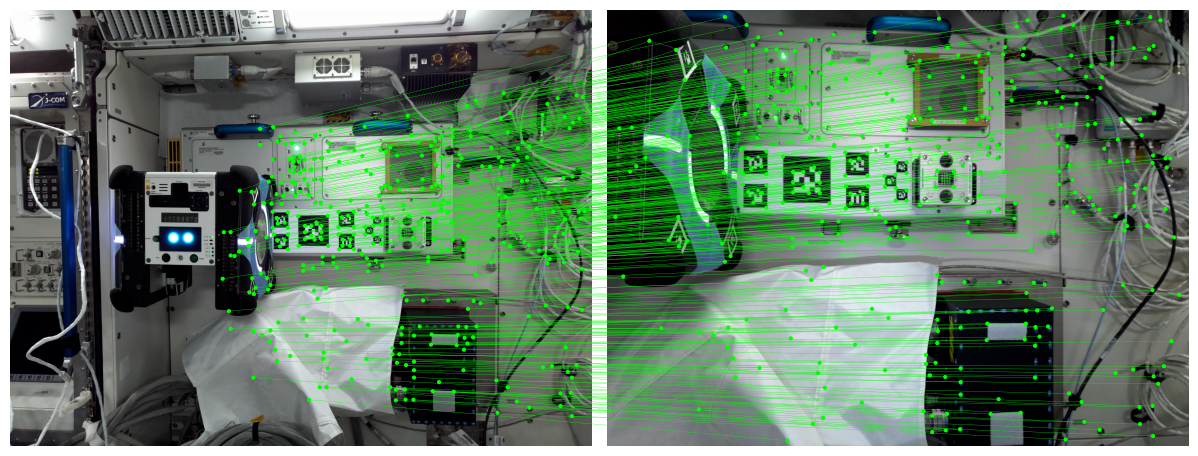

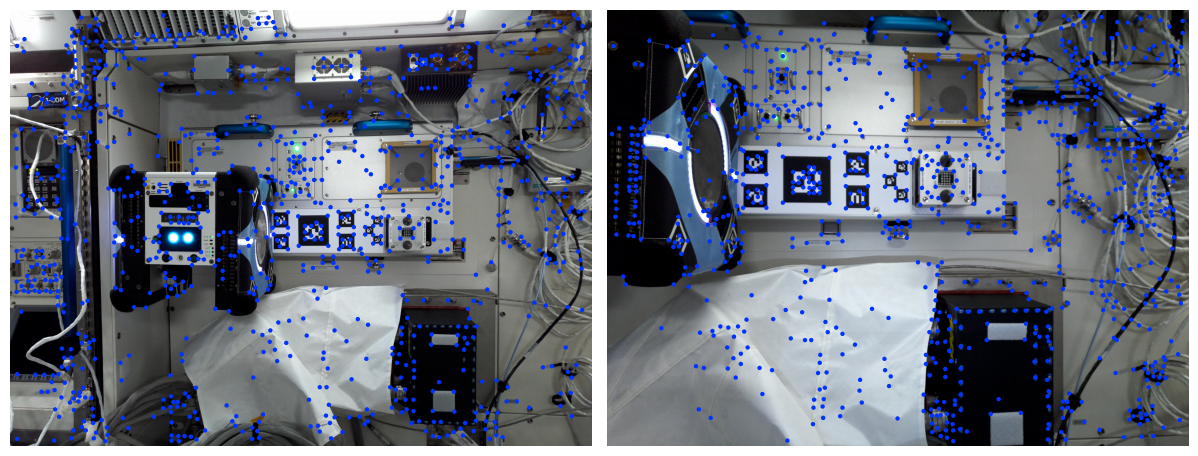

In [3]:
image0 = load_image(image0_path)
image1 = load_image(image1_path)

#image1 = torchvision.transforms.functional.rotate(image1, 90)

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0_no_batch_dim, feats1_no_batch_dim, matches01_no_batch_dim = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0_no_batch_dim["keypoints"], feats1_no_batch_dim["keypoints"], matches01_no_batch_dim["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
#viz2d.add_text(0, f'Stopped after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01_no_batch_dim["prune0"]), viz2d.cm_prune(matches01_no_batch_dim["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

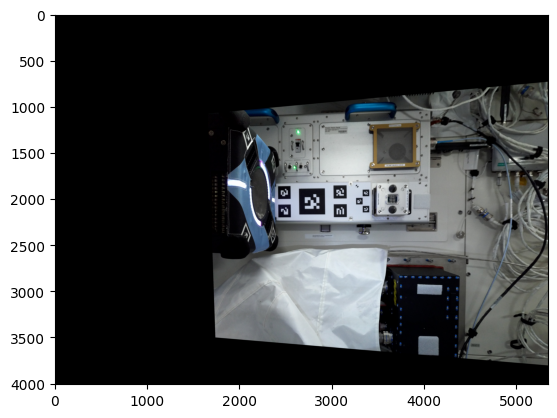

In [4]:
CV_image0 = cv.imread(image0_path)
CV_image1 = cv.imread(image1_path)

# Homography estimation
homography_result = cv.findHomography(m_kpts1.cpu().numpy(), m_kpts0.cpu().numpy(), cv.RANSAC, 5.0)

transformed_image = cv.warpPerspective(CV_image1, homography_result[0], (CV_image0.shape[1], CV_image0.shape[0]))

plt.imshow(cv.cvtColor(transformed_image, cv.COLOR_BGR2RGB))